In [2]:
from lxml import etree as ET
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
import matplotlib.ticker as ticker

# `find_nearest_centroids()`: Execution time

## Parsing measurements from xml output of testing framework

In [3]:
!head -n 10 find_nearest_centroids.xml

<?xml version="1.0" encoding="UTF-8"?>
<Catch name="testmain" filters="[Index][find_nearest_centroids][benchmark]">
  <Group name="testmain">
    <TestCase name="Scenario: find_nearest_centroids()" tags="[Index][SIFT1M][benchmark][find_nearest_centroids]" filename="tests/IndexTest.cpp" line="344">
      <Section name="Given: the SIFT1M dataset" filename="tests/IndexTest.cpp" line="346">
        <Section name="Then: all required files are present" filename="tests/IndexTest.cpp" line="367">
          <OverallResults successes="5" failures="0" expectedFailures="0"/>
        </Section>
        <OverallResults successes="5" failures="0" expectedFailures="0"/>
      </Section>


In [4]:
# parse xml from find_nearest_centroids.xml
tree = ET.parse('find_nearest_centroids.xml')
root = tree.getroot()

In [5]:
# read `n_lists` and `n_probe` benchmark parameters which are stored in a `Warning` tag (key := value) preceding the `BenchmarkResults` tag
def extract_benchmark_params(element):
    params = {}
    for sibling in element.itersiblings(preceding=True):
        if sibling.tag == 'Warning':
            parts = list(map(lambda s: s.strip(), sibling.text.split(':=')))
            params[parts[0]] = parts[1]
    return params

results = []
for match in root.iter('BenchmarkResults'):
    result = extract_benchmark_params(match)
    result['mean'] = match.find('mean').get('value')
    result['std'] = match.find('standardDeviation').get('value')
    results.append(result)

In [6]:
# find StdOut tag where the benchmark also wrote the insertion time of `bulk_insert_entries` (which we haven't look at for varying n_lists n_probe so far)
stdout = root.find('.//StdOut')
stdout_text = stdout.text
bulk_insert_durations = []
for line in stdout_text.split('\n'):
  if 'took' in line:
    seconds = line.lstrip('bulk_insert_entries: took ').rstrip(' s')
    bulk_insert_durations.append(float(seconds))
# merge bulk_insert_durations with results
for i in range(len(results)):
  results[i]['bulk_insert_duration'] = bulk_insert_durations[i]

In [7]:
# convert results to dataframe
centroids_df = pd.DataFrame(results)
centroids_df['mean'] = centroids_df['mean'].astype(float)
centroids_df['std'] = centroids_df['std'].astype(float)
centroids_df['n_probe'] = centroids_df['n_probe'].astype(int)
centroids_df['n_lists'] = centroids_df['n_lists'].astype(int)
# convert mean and std from nanoseconds to seconds
centroids_df['mean'] = centroids_df['mean'] / 1e9
centroids_df['std'] = centroids_df['std'] / 1e9
# reorder columns as 'n_lists', 'n_probe', 'mean', 'std', 'bulk_insert_duration'
centroids_df = centroids_df[['n_lists', 'n_probe', 'mean', 'std', 'bulk_insert_duration']]
centroids_df


,n_lists,n_probe,mean,std,bulk_insert_duration
0,256,1,1.36116,0.001869,1.81992
1,256,2,1.38355,0.002081,1.83195
2,256,4,1.42964,0.000129,1.81749
3,256,8,1.53660,0.009250,1.80262
4,256,16,1.68321,0.002342,1.87537
5,256,32,1.97958,0.001106,1.87103
6,256,64,2.42210,0.001428,1.87679
7,256,128,3.00172,0.000300,1.80231
8,512,1,2.69723,0.000423,2.07676
9,512,2,2.72730,0.001677,2.00754


## Computing search space size and size of keeping track of the candidates
- Since we're searching through the SIFT1M dataset with $10^6$ vectors, we can compute the number of vectors per list `n_vectors_per_list` given the number of lists `n_lists`:
$$
\text{n\_vectors\_per\_list} = \frac{10^6}{\text{n\_lists}}
$$.
- We find the total number of vectors which need to be searched as the product of `n_vectors_per_list` and `n_probe`, therefore:

$$
\text{n\_vectors\_to\_search} = \text{n\_vectors\_per\_list} * \text{n\_probe} = \frac{10^6}{\text{n\_lists}} * \text{n\_probe}
$$.

- Assuming $128$-dimensional vectors of floats, we can estimate the size of the search space in MB as:
$$
\text{search\_space\_size\_mb} = \text{n\_vectors\_to\_search} * \frac{128 * 4}{2^{20}}
$$.

- Since the heap needs to hold `n_probe` centroid candidates, we can estimate the size of the candidates in KB as:
$$
\text{candidates\_size\_mb} = \text{n\_probe} * \frac{128 * 4}{2^{10}}
$$.


In [8]:
def add_space_estimates(df):
  df['n_vectors_to_search'] = 10 ** 6 // df['n_lists'] * df['n_probe']
  df['search_space_size_mb'] = (df['n_vectors_to_search'] * 128 * 4 / 2**20).round(2)
  df['candidates_size_kb'] = (df['n_probe'] * 128 * 4 / 2**10).round(2)

## Visualizing execution time

In [9]:
marker_cycler = cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
                         '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
                         '#bcbd22', '#17becf'], marker=['o', 's', '^', 'd', '*', '+', 'x', 'v', 'p', 'h'])

In [10]:
add_space_estimates(centroids_df)
centroids_ex_time_mean = centroids_df.groupby('n_lists').mean()
centroids_ex_time_std = centroids_df.groupby('n_lists').std()
centroids_ex_time_mean

,n_probe,mean,std,bulk_insert_duration,n_vectors_to_search,search_space_size_mb,candidates_size_kb
n_lists,,,,,,,
256,31.875,1.849695,0.002313,1.837185,124503.750,60.79250,15.9375
512,31.875,3.350209,0.002285,2.058088,62251.875,30.39625,15.9375
1024,31.875,6.175323,0.003696,62.315562,31110.000,15.19000,15.9375
2048,31.875,11.696475,0.002462,84.705475,15555.000,7.59500,15.9375
4096,31.875,22.542113,0.002881,106.122362,7777.500,3.79750,15.9375


### Results of `find_nearest_centroids()`
- As we can see in the below loglog plot, `find_nearest_centroids` scales linearly with the number of lists.
- The number of closest centroids to find (`n_probe`) becomes less relevant the higher the amount of centroids is we need to compare against (`n_lists`).
- On average over all probes, it takes around $5.5$ s to find the closest centroids among $1000$ lists.

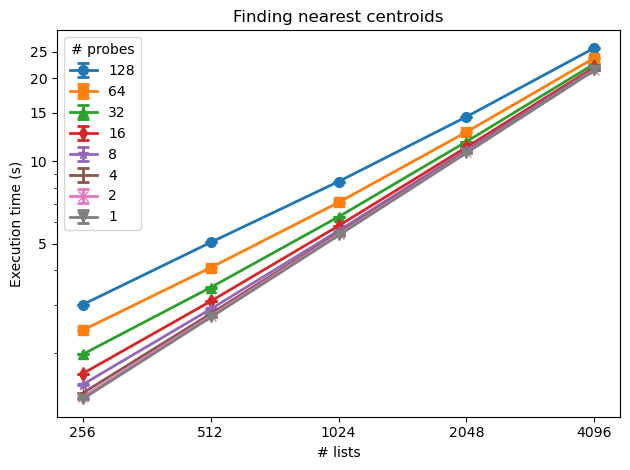

In [12]:
fig, ax = plt.subplots(tight_layout=True)
ax.set_prop_cycle(marker_cycler)
ax.set_title('Finding nearest centroids')
for n_probe in reversed(sorted(centroids_df['n_probe'].unique())):
    df_subset = centroids_df[centroids_df['n_probe'] == n_probe]
    ax.errorbar(df_subset['n_lists'], df_subset['mean'], label=f'{n_probe}', yerr=df_subset['std'], capsize=4, capthick=2, markersize=7, lw=2)
# ax.errorbar(centroids_ex_time_mean.index, centroids_ex_time_mean['mean'], label='Mean execution time', markersize=6, lw=2, yerr=centroids_ex_time_std['mean'], capsize=4, capthick=2)
ax.set_xlabel('# lists')
ax.set_xscale('log')
ax.xaxis.set_major_locator(ticker.LogLocator(base=2))
ax.xaxis.set_minor_locator(ticker.NullLocator())
ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=False))

ax.set_ylabel('Execution time (s)')
ax.set_yscale('log')
locator = ticker.MultipleLocator(5)
plt.gca().yaxis.set_major_locator(locator)
formatter = ticker.StrMethodFormatter("{x:.0f}")
plt.gca().yaxis.set_major_formatter(formatter)

# ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=False))
ax.legend(title='# probes')
plt.show()



In [22]:
seconds_per_list = centroids_ex_time_mean.at[4096, 'mean'] / 4096 * 1000
print(f'`find_nearest_centroids` needs {seconds_per_list:.1f} s per 1000 lists')
centroids_ex_time_mean

`find_nearest_centroids` needs 5.5 s per 1000 lists


,n_probe,mean,std,bulk_insert_duration,n_vectors_to_search,search_space_size_mb,candidates_size_kb
n_lists,,,,,,,
256,31.875,1.849695,0.002313,1.837185,124503.750,60.79250,15.9375
512,31.875,3.350209,0.002285,2.058088,62251.875,30.39625,15.9375
1024,31.875,6.175323,0.003696,62.315562,31110.000,15.19000,15.9375
2048,31.875,11.696475,0.002462,84.705475,15555.000,7.59500,15.9375
4096,31.875,22.542113,0.002881,106.122362,7777.500,3.79750,15.9375


# `bulk_insert_entries`: Execution time
- In the following loglog plot, we see the insertion time scales linearly with varying `n_lists` which we haven't look at so far.
- `n_probe` doesn't affect the execution time of `bulk_insert_entries` as we would expect.
- From $512$ to $1024$ lists, we notice a jump in execution time of about two orders of magnitude. Since the average search space decreases and the average size of the candidates set is constant, we can conclude that the jump is likely caused by a more spread out distribution of active write locations due to the large `n_lists`. The cache might not be able to keep all tails of the lists and has to fetch them from main memory more often.

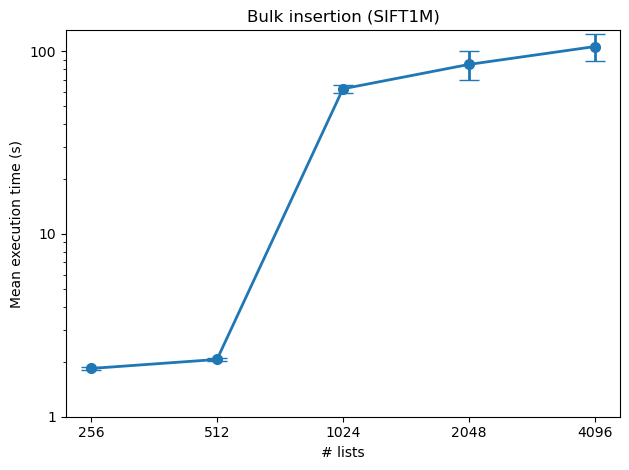

In [14]:
fig, ax = plt.subplots(tight_layout=True)
ax.set_prop_cycle(marker_cycler)
ax.set_title('Bulk insertion (SIFT1M)')
# for n_probe in sorted(centroids_df['n_probe'].unique()):
#     df_subset = centroids_df[centroids_df['n_probe'] == n_probe]
#     ax.plot(df_subset['n_lists'], df_subset['bulk_insert_duration'], label=f'{n_probe}', markersize=6, lw=2)
ax.errorbar(centroids_ex_time_mean.index, centroids_ex_time_mean['bulk_insert_duration'], label='Mean execution time', markersize=7, lw=2, yerr=centroids_ex_time_std['bulk_insert_duration'], capsize=7)

ax.set_ylim(bottom=1)

ax.set_xlabel('# lists') 
ax.set_xscale("log")
ax.xaxis.set_major_locator(ticker.LogLocator(base=2))
ax.xaxis.set_minor_locator(ticker.NullLocator())
ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=False))

ax.set_ylabel('Mean execution time (s)')
ax.set_yscale('log')
ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=False))

# ax.legend(title='# probes', loc='upper left')
plt.show()

# `search_preassigned`: Execution time

## Parsing measurements from log file
- Note that the execution time measured includes the time to find the nearest centroids, which we will exclude in a following step.

In [15]:
!head -n 10 search_preassigned.log


Filters: [Index][search_preassigned][benchmark]
Inserted 1000000 entries of 1000000 (100%)
bulk_insert_entries: took 1.80958 s
search_preassigned() with n_lists=256 and n_probe=1

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
testmain is a Catch v2.13.10 host application.
Run with -? for options



In [16]:
!tail -n 15 search_preassigned.log

tests/IndexTest.cpp:314
...............................................................................

benchmark name                       samples       iterations    estimated
                                     mean          low mean      high mean
                                     std dev       low std dev   high std dev
-------------------------------------------------------------------------------
search_preassigned(): includes                                                 
finding the nearest centroids                    3             1     9.64633 m 
                                         3.21314 m     3.21289 m     3.21328 m 
                                        10.9139 ms          0 ns    11.9666 ms 
                                                                               

All tests passed (320 assertions in 1 test case)


In [17]:
results = []
parse_next_lines = 0
with open('search_preassigned.log', 'r') as f:
  for line in f:
    if 'bulk_insert_entries: took ' in line:
      seconds = line.lstrip('bulk_insert_entries: took ')
      seconds = seconds.rstrip(' s\n')
      results.append({'bulk_insert_duration': float(seconds)})
    elif 'search_preassigned() with n_lists=' in line:
      n_lists = line.split('n_lists=')[1].split(' ')[0]
      n_probe = line.split('n_probe=')[1].split(' ')[0]
      results[-1]['n_lists'] = int(n_lists)
      results[-1]['n_probe'] = int(n_probe)
    elif 'finding the nearest centroids ' in line:
      parse_next_lines = 2
    elif parse_next_lines == 2:
      parts = line.lstrip().split(' ')
      mean = float(parts[0])
      if parts[1] == 'm':
        mean *= 1e3
      results[-1]['mean'] = mean
      parse_next_lines -= 1
    elif parse_next_lines == 1:
      parts = line.lstrip().split(' ')
      std = float(parts[0])
      assert parts[1] == 'ms'
      std /= 1e3
      results[-1]['std'] = float(std)
      parse_next_lines -= 1

In [18]:
# convert results to dataframe
search_df = pd.DataFrame(results)
search_df['mean'] = search_df['mean'].astype(float)
search_df['std'] = search_df['std'].astype(float)
search_df['n_probe'] = search_df['n_probe'].astype(int)
search_df['n_lists'] = search_df['n_lists'].astype(int)
# reorder coluns as 'n_lists', 'n_probe', 'mean', 'std', 'bulk_insert_duration'
search_df = search_df[['n_lists', 'n_probe', 'mean', 'std', 'bulk_insert_duration']]
print(np.sqrt(pow(0.070223, 2) + pow(0.001869, 2)))
# add space estimates
add_space_estimates(search_df)
search_df

0.0702478675121174


,n_lists,n_probe,mean,std,bulk_insert_duration,n_vectors_to_search,search_space_size_mb,candidates_size_kb
0,256,1,23.4349,0.070223,1.80958,3906,1.91,0.5
1,256,2,44.9702,0.133880,1.76407,7812,3.81,1.0
2,256,4,1450.7400,0.027703,1.75547,15624,7.63,2.0
3,256,8,2831.9100,0.029452,1.83086,31248,15.26,4.0
4,256,16,5547.2900,0.134838,1.75532,62496,30.52,8.0
5,256,32,10893.2000,0.027022,1.77186,124992,61.03,16.0
6,256,64,21443.2000,0.259208,1.76177,249984,122.06,32.0
7,256,128,42620.6000,0.321753,1.76634,499968,244.12,64.0
8,512,1,14.1529,0.082002,2.21337,1953,0.95,0.5
9,512,2,25.0455,0.055491,2.09262,3906,1.91,1.0


In [19]:
centroids_df

,n_lists,n_probe,mean,std,bulk_insert_duration,n_vectors_to_search,search_space_size_mb,candidates_size_kb
0,256,1,1.36116,0.001869,1.81992,3906,1.91,0.5
1,256,2,1.38355,0.002081,1.83195,7812,3.81,1.0
2,256,4,1.42964,0.000129,1.81749,15624,7.63,2.0
3,256,8,1.53660,0.009250,1.80262,31248,15.26,4.0
4,256,16,1.68321,0.002342,1.87537,62496,30.52,8.0
5,256,32,1.97958,0.001106,1.87103,124992,61.03,16.0
6,256,64,2.42210,0.001428,1.87679,249984,122.06,32.0
7,256,128,3.00172,0.000300,1.80231,499968,244.12,64.0
8,512,1,2.69723,0.000423,2.07676,1953,0.95,0.5
9,512,2,2.72730,0.001677,2.00754,3906,1.91,1.0


### Correcting the estimated execution time of `search_preassigned`

In the first benchmark, the measurement of `search_preassigned` includes both the execution time of the function itself as well as the required preprocessing step `find_nearest_centroids`. In the following, we will correct the execution time of `search_preassigned` using the estimated execution time of the preprocessing step `find_nearest_centroids` of the second benchmark.

Let $S$, $C$ be normally distributed i.d.d. random variables for the actual execution times of `search_preassigned` and `find_nearest_centroids`, respectively. Then, the measured execution time $X$ of `search_preassigned` can be written as $X=C+S$ with $C$ and $S$ independent. We estimate the actual execution time of `search_preassigned` by subtracting the estimated execution time of `find_nearest_centroids` from the measured execution time of `search_preassigned`.

$$
E[S] = E[X - C] = E[X] - E[C] =: \mu
$$
$$
Var[S] = Var[X - C] = Var[X] + Var[C] =: \sigma^2
\implies \sigma = \sqrt{\sigma_X^2 + \sigma_C^2}
$$

In [20]:
corrected_search_df = search_df.copy()
corrected_search_df['mean'] = search_df['mean'] - centroids_df['mean']
corrected_search_df['std'] = np.sqrt(search_df['std']**2 + search_df['std']**2)
corrected_search_df

,n_lists,n_probe,mean,std,bulk_insert_duration,n_vectors_to_search,search_space_size_mb,candidates_size_kb
0,256,1,22.07374,0.099310,1.80958,3906,1.91,0.5
1,256,2,43.58665,0.189335,1.76407,7812,3.81,1.0
2,256,4,1449.31036,0.039178,1.75547,15624,7.63,2.0
3,256,8,2830.37340,0.041652,1.83086,31248,15.26,4.0
4,256,16,5545.60679,0.190690,1.75532,62496,30.52,8.0
5,256,32,10891.22042,0.038215,1.77186,124992,61.03,16.0
6,256,64,21440.77790,0.366575,1.76177,249984,122.06,32.0
7,256,128,42617.59828,0.455027,1.76634,499968,244.12,64.0
8,512,1,11.45567,0.115969,2.21337,1953,0.95,0.5
9,512,2,22.31820,0.078476,2.09262,3906,1.91,1.0


- In this loglog plot, we see that `search_preassigned` scales linearly with the number of probes `n_probe`.
- There is one obvious jump in execution time by two orders of magnitude, regularly depending on both `n_probe` and `n_lists`.
- Based on the size estimations above, for `n_lists` between $256$ and $2048$,
   - it could be that the jump is caused by the size of the search space surpassing the size of the L3 cache, with an estimated size of around $8$ MB, and having to access main memory more often.
- For `n_lists` equal $4096$,
  - we see that this jump already occurs significantly earlier, which could be caused by the working set, including the `n_probe` centroids candidates, surpassing the size of the L1 cache, estimated around $8$ KB.
  - Another explanation could be that due to the large number of lists, the lists cannot be stored as compactly on disk and therefore require overall more space on disk and also in the cache, compared to fewer more compactly stored lists.
  - To gain more insights into this, one could also track the `total_size`, i.e. the actual size the data occupies on disk.

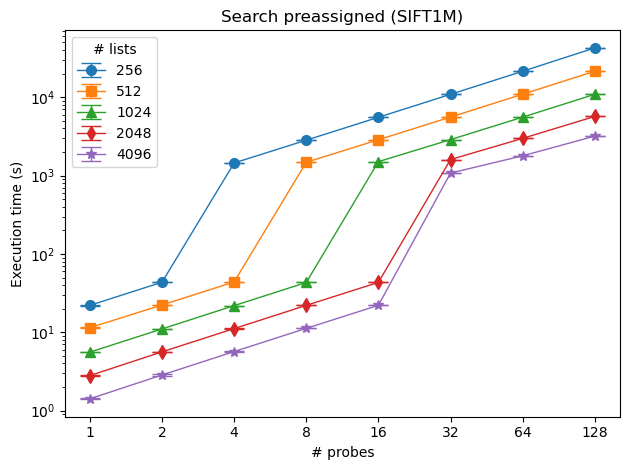

In [21]:
fig, ax = plt.subplots(tight_layout=True)
ax.set_prop_cycle(marker_cycler)
ax.set_title('Search preassigned (SIFT1M)')
for n_lists in sorted(corrected_search_df['n_lists'].unique()):
    df_subset = corrected_search_df[corrected_search_df['n_lists'] == n_lists]
    ax.errorbar(df_subset['n_probe'], df_subset['mean'], label=f'{n_lists}', yerr=df_subset['std'], capsize=7, markersize=7, lw=1)

ax.set_xlabel('# probes')
ax.set_xscale('log')
ax.xaxis.set_major_locator(ticker.LogLocator(base=2))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.xaxis.set_minor_locator(ticker.NullLocator())

ax.set_ylabel('Execution time (s)')
ax.set_yscale('log')


ax.legend(title='# lists')
plt.show()

